<a href="https://colab.research.google.com/github/fed21/Neural-Network-Project/blob/main/NN_Project_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks Project
Neural Networks course at Sapienza University of Rome
## Breast Cancer Detection: Augmenting Convolutional networks with attention-based aggregation

*   Filippo Betello 1835108 
*   Federico Carmignani 1845479

Reference paper source: https://arxiv.org/pdf/2112.13692.pdf



## Installation of Packages
Here the Timm package is installed to be used afterwards.
PyTorch Image Models (timm) is a collection of image models, layers, utilities, optimizers, schedulers, data-loaders / augmentations, and reference training / validation scripts.

In [ ]:
#Timm installation
print("\u001b[31m")
!pip install timm

print("\u001b[31m[OK] Timm package installed successfully")


     |████████████████████████████████| 431 kB 5.4 MB/s 
[OK] Timm package installed successfully


## Imports of libraries and dependencies 
Here the libraries and dependencies used in the implementation are imported.

In [ ]:
#System and Data imports
import os
import json
from functools import partial
from typing import Optional

#MatPlotLib and Numpy imports
import numpy as np
import matplotlib.pyplot as plt

#Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

#TorchVision imports
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets.folder import ImageFolder, default_loader
from torchvision.transforms.transforms import Resize

#Timm imports
import timm
from timm.data import create_transform
from timm.models.efficientnet_blocks import SqueezeExcite
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

print("\u001b[31m[OK] Libraries and dependencies imported successfully")

[OK] Libraries and dependencies imported successfully


## Preparation of the dataset: CIFAR10
Here the dataset is:

1.   downloaded
2.   augmented
3.   splitted in training and test phases using specific dataloaders.


In [ ]:
#Building and organizing the dataset (CIFAR10)
def build_dataset_CIFAR10():
    #Creating Transform element for Augmentation of the dataset in Training phase
    transform_train = transforms.Compose([
                                          transforms.RandomHorizontalFlip(), #Flips the image w.r.t horizontal axis
                                          transforms.RandomRotation(10),     #Rotates the image to a specified angle
                                          transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles
                                          transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Customizes the color params 
                                          #transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                         )    
    
    #Creating Transform element for Resize of the dataset in Testing phase
    transform = transforms.Compose([
                                    #transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                  )
    
    #Defining the batch size for training and testing phases: as usual a multiple of 2 is chosen
    batch_size = 20
    
    print("\u001b[31m")

    #Training phase: downloading the dataset and creation of the dataloader
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    #Test phase: downloading the dataset and creation of the dataloader
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False)

    #Returning dataset chunks and loaders for both Training and Testing phase, as well as the batch size defined
    return trainset, trainloader, testset, testloader, batch_size



In [ ]:
#Enumerating the 10 classes of the dataset CIFAR10 
#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#Building and splitting the dataset using the method above
trainset, trainloader, testset, testloader, batch_size = build_dataset_CIFAR10()

print("\u001b[31m[OK] Dataset downloaded and splitted successfully")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[OK] Dataset downloaded and splitted successfully


## Device configuration
A GPU is usually used to exploit its velocity in image processing, if it is not available in Colab then a CPU is assigned for availability reasons.

In [ ]:
#Setting GPU (Cuda) as default device, otherwise CPU is assigned
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("\u001b[31m",device)
print("\u001b[31m[OK] Device configured successfully")

 cuda:0
[OK] Device configured successfully


## Resnet50 model
A residual neural network (ResNet) is an artificial neural network (ANN). Residual neural networks utilize skip connections, or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between.
ResNet-50 is a convolutional neural network that is 50 layers deep. The pretrained network can classify images into 1000 object categories. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.
We are going to use it as a basis for comparison with the innovative architecture PatchConvNet implemented in the following section. Note that this ResNet50 has a value of output features equal to 10 according to CIFAR10.

In [ ]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])



#Resnet50 model is saved from PyTorch into the device used
model_resnet50 = ResNet50()
model = model_resnet50.to(device)

#Setting Loss Function
criterion = nn.CrossEntropyLoss()
#Setting Optimizer as SGD with learning rate 0.01 and weight decay 0.01 to avoid overfitting
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

print("\u001b[31m[OK] Resnet50 configured successfully")
print(model)

[OK] Resnet50 configured successfully
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

## MODEL PATCH CONV

In [ ]:
class Mlp(nn.Module):
    def __init__(
        self,
        in_features: int,
        hidden_features: Optional[int] = None,
        out_features: Optional[int] = None,
        act_layer: nn.Module = nn.GELU,
        drop: float = 0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x



class Learned_Aggregation_Layer(nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int = 1,
        qkv_bias: bool = False,
        qk_scale: Optional[float] = None,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ):
        super().__init__()
        self.num_heads = num_heads
        head_dim: int = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim**-0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.k = nn.Linear(dim, dim, bias=qkv_bias)
        self.v = nn.Linear(dim, dim, bias=qkv_bias)
        self.id = nn.Identity()
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        q = self.q(x[:, 0]).unsqueeze(1).reshape(B, 1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = self.k(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        q = q * self.scale
        v = self.v(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        attn = q @ k.transpose(-2, -1)
        attn = self.id(attn)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x_cls = (attn @ v).transpose(1, 2).reshape(B, 1, C)
        x_cls = self.proj(x_cls)
        x_cls = self.proj_drop(x_cls)

        return x_cls




class Layer_scale_init_Block_only_token(nn.Module):
    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        qk_scale: Optional[float] = None,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: nn.Module = nn.GELU,
        norm_layer=nn.LayerNorm,
        Attention_block=Learned_Aggregation_Layer,
        Mlp_block=Mlp,
        init_values: float = 1e-4,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention_block(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp_block(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x: torch.Tensor, x_cls: torch.Tensor) -> torch.Tensor:
        u = torch.cat((x_cls, x), dim=1)
        x_cls = x_cls + self.drop_path(self.gamma_1 * self.attn(self.norm1(u)))
        x_cls = x_cls + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x_cls)))
        return x_cls




class Conv_blocks_se(nn.Module):                                # UNO column/trunk va moltiplicato xN = depth
    def __init__(self, dim: int):
        super().__init__()

        self.qkv_pos = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(dim, dim, groups=dim, kernel_size=3, padding=1, stride=1, bias=True),
            nn.GELU(),
            SqueezeExcite(dim, rd_ratio=0.25),
            nn.Conv2d(dim, dim, kernel_size=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        H = W = int(N ** 0.5)
        x = x.transpose(-1, -2)
        x = x.reshape(B, C, H, W)
        x = self.qkv_pos(x)
        x = x.reshape(B, C, N)
        x = x.transpose(-1, -2)
        return x



class Layer_scale_init_Block(nn.Module):
    def __init__(
        self,
        dim: int,
        drop_path: float = 0.0,
        act_layer: nn.Module = nn.GELU,
        norm_layer=nn.LayerNorm,
        Attention_block=None,
        init_values: float = 1e-4,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention_block(dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))




def conv3x3(in_planes: int, out_planes: int, stride: int = 1) -> nn.Sequential:
    """3x3 convolution with padding"""
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False),
    )



class ConvStem(nn.Module):
    """Image to Patch Embedding"""

    def __init__(self, img_size: int = 32, patch_size: int = 4, in_chans: int = 3, embed_dim: int = 768):
        super().__init__()
        img_size = to_2tuple(img_size)          # (32, 32)
        patch_size = to_2tuple(patch_size)      # (4, 4)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])           # 64
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Sequential(                          # da 3 a embed_dim dimensione dei planes        # maybe change GELU with RELU ??
            conv3x3(in_chans, embed_dim // 8, 2),
            nn.GELU(),
            conv3x3(embed_dim // 8, embed_dim // 4, 2),
            nn.GELU(),
            conv3x3(embed_dim // 4, embed_dim // 2, 2),
            nn.GELU(),
            conv3x3(embed_dim // 2, embed_dim, 2),
        )

    def forward(self, x: torch.Tensor, padding_size: Optional[int] = None) -> torch.Tensor:
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class PatchConvnet(nn.Module):

    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=768, depth=12,
                 num_heads=1, qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm, global_pool=None,
                 block_layers = Layer_scale_init_Block,
                 block_layers_token = Layer_scale_init_Block_only_token,
                 Patch_layer=ConvStem,act_layer=nn.GELU,
                 Attention_block = Conv_blocks_se ,
                dpr_constant=True,init_scale=1e-4,
                Attention_block_token_only=Learned_Aggregation_Layer,
                Mlp_block_token_only= Mlp,
                depth_token_only=1,
                mlp_ratio_clstk = 3.0,
                multiclass=False):
        super().__init__()

        self.multiclass = multiclass
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        self.patch_embed = Patch_layer(     # convolutional steam
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        
        if not self.multiclass:             # monoclass --> crea un solo token per tutte le classi matrice di 0 di 768dim
            self.cls_token = nn.Parameter(torch.zeros(1, 1, int(embed_dim)))
        
        dpr = [drop_path_rate for i in range(depth)]        # ARRAY DI 0 DI LEN = DEPTH = 12
            
        self.blocks = nn.ModuleList([                       # SINGOLI BLOCCHI DENTRO COLUMN TRUNCK DI NUM = DEPTH
            block_layers(
                dim=embed_dim, drop_path=dpr[i], norm_layer=norm_layer,
                act_layer=act_layer,Attention_block=Attention_block,init_values=init_scale)
            for i in range(depth)])
                    
        
        self.blocks_token_only = nn.ModuleList([            # SINGOLI BLOCCHI DENTRO COLUMN TRUNCK DI NUM = DEPTH + TOKEN
            block_layers_token(
                dim=int(embed_dim), num_heads=num_heads, mlp_ratio=mlp_ratio_clstk,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=0.0, norm_layer=norm_layer,
                act_layer=act_layer,Attention_block=Attention_block_token_only,
                Mlp_block=Mlp_block_token_only,init_values=init_scale)
            for i in range(depth_token_only)])
        
        self.norm = norm_layer(int(embed_dim))              # NORMALIZATION PART
        
        self.total_len = depth_token_only+depth             # PROFONDIT TOTALE DELLA RETE --> 1+12 = 13
        
        self.feature_info = [dict(num_chs=int(embed_dim ), reduction=0, module='head')]         # [{'num_chs': 768, 'reduction': 0, 'module': 'head'}]  DICTIONARY
        if not self.multiclass:
            self.head = nn.Linear(int(embed_dim), num_classes) if num_classes > 0 else nn.Identity()        # PAPER DA INFO SUL PERCHè USIAMO QUESTO --> IN PRIMA PAGINA
        


        trunc_normal_(self.cls_token, std=.02)              # FUNCTION IMPORTED FROM TIMM.LAYERS
        self.apply(self._init_weights)
        ################################################ FINE INIT  #########################################################

    def _init_weights(self, m):         ## DA CAPIRE
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token'}

    def get_classifier(self):
        return self.head
    
    def get_num_layers(self):
        return len(self.blocks)
    

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        
        for i , blk in enumerate(self.blocks):
            x  = blk(x)

        for i , blk in enumerate(self.blocks_token_only):
            cls_tokens = blk(x,cls_tokens)
        x = torch.cat((cls_tokens, x), dim=1)

        x = self.norm(x)
        
        if not self.multiclass:
            return x[:, 0]
        else:
            return x[:, :self.num_classes].reshape(B,self.num_classes,-1)

    def forward(self, x):
        B = x.shape[0]
        x  = self.forward_features(x)
        if not self.multiclass:
            x = self.head(x)
            return x
        else:
            all_results = []
            for i in range(self.num_classes):
                all_results.append(self.head[i](x[:,i]))
            return torch.cat(all_results,dim=1).reshape(B,self.num_classes)

@register_model
def S60(pretrained: bool = False, **kwargs):
    model = PatchConvnet(
        patch_size=4,
        embed_dim=384,
        depth=60,
        num_heads=1,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        Patch_layer=ConvStem,
        Attention_block=Conv_blocks_se,
        depth_token_only=1,
        mlp_ratio_clstk=3.0,
        **kwargs
    )

    return model
        

In [ ]:
model = S60()
model = model.to(device)
print(model)

RuntimeError: ignored

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)   #ADAM

## Lamb optimizer

In [ ]:
!pip install torch_optimizer

     |████████████████████████████████| 61 kB 474 kB/s 


In [ ]:
import torch_optimizer as optime

optimizer = optime.Lamb(model.parameters(), lr = 0.01)

NameError: ignored

## Mounting drive folders
This job is done to save models pretrained.

In [ ]:
from google.colab import drive # import drive from google colab
import time
print("\u001b[31m")
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/NN/Model/patch_0101.pth'

print("\u001b[31m[OK] Drive mounted successfully")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[OK] Drive mounted successfully


## EarlyStopping
Early stopping is a form of regularization used to avoid overfitting on the training dataset. Early stopping keeps track of the validation loss, if the loss stops decreasing for several epochs in a row the training stops. The EarlyStopping class in is used to create an object to keep track of the validation loss while training a PyTorch model. It will save a checkpoint of the model each time the validation loss decrease. We set the patience argument in the EarlyStopping class to how many epochs we want to wait after the last time the validation loss improved before breaking the training loop.
This because when training a pretrained one, overfitting is possible: training accuracy is greater than validation one.

In [ ]:
#Defining EarlyStopping to avoid overfitting during training
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

print("\u001b[31m[OK] EarlyStopping defined successfully")

[OK] EarlyStopping defined successfully


## Training and validation

In [ ]:
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=10, verbose=True)

## Transfer learning with fine tuning
#model.load_state_dict(torch.load(PATH))
#model.eval()

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    total = 0
    total_val = 0
 
    model.train() #prepare for training
    for inputs, labels in trainloader:

        #print(inputs)
        
        inputs = inputs.to(device, non_blocking=True) # input to device as our model is running in mentioned device.
        labels = labels.to(device, non_blocking=True)
        outputs = model(inputs) #the output will be a tensor element of size 10 (num_classes), then the max is taken to address the predcited class
       # print(outputs.shape)
        # zero the parameter gradients
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        # forward + backward + optimize
       
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1) #the max is taken to address the predcited class
        total += labels.size(0)
        running_loss += loss.item() 
        running_corrects += (preds == labels.data).sum().item()

    else:

      with torch.no_grad(): # we do not need gradient for validation.
        model.eval() # prep model for evaluation
        for val_inputs, val_labels in testloader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)
          
          _, val_preds = torch.max(val_outputs, 1)
          total_val +=  val_labels.size(0)
          val_running_loss += val_loss.item()
          val_running_corrects += (val_preds == val_labels.data).sum().item()
      
    epoch_loss = running_loss/len(trainloader) # loss per epoch
    epoch_acc = 100 * running_corrects/total # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(testloader)
    val_epoch_acc = 100 * val_running_corrects/total_val
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc))
    
     #early_stopping needs the validation loss to check if it has decresed, 
        #and if it has, it will make a checkpoint of the current model
    early_stopping(val_epoch_loss, model)
        
    if early_stopping.early_stop:
          print("Early stopping")
          break

#load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

torch.save(model.state_dict(), PATH)
print('Finished Training')

RuntimeError: ignored

### Plot Results

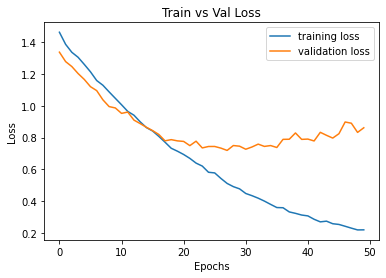

In [ ]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()

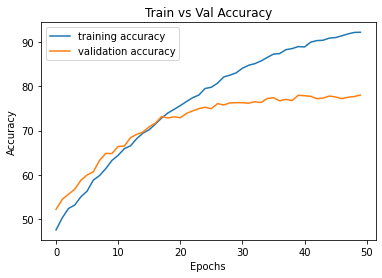

In [ ]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.legend()

## Print output

In [ ]:
!pip install vit-pytorch

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
from PIL import Image
import requests
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
import warnings

from vit_pytorch.recorder import Recorder, find_modules


warnings.filterwarnings("ignore")

In [ ]:
class visualizer(nn.Module):
    #Slightly modified code from Lucidrains (https://github.com/lucidrains)
    #Original code: https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/recorder.py
    def __init__(self, model):
        super().__init__()
        self.model = model

        self.data = None
        self.recordings = []
        self.hooks = []
        self.hook_registered = False
        self.ejected = False

    def _hook(self, _, input, output):
        self.recordings.append(output.clone().detach())

        
    def _register_hook(self):
        handle = self.model.blocks_token_only[0].attn.id.register_forward_hook(self._hook)
        self.hooks.append(handle)
        self.hook_registered = True
        
    def eject(self):
        self.ejected = True
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        return self.model

    def clear(self):
        self.recordings.clear()

    def record(self, x):
        recording = x.clone().detach()
        self.recordings.append(recording)

    def forward(self, img):
        assert not self.ejected, 'recorder has been ejected, cannot be used anymore'
        self.clear()

        if not self.hook_registered:
            self._register_hook()

        pred = self.model(img)
        return pred, self.recordings  

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def get_transforms_original(input_size=32,test_size=32,mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]):

    transformations = transforms.Compose(
        [transforms.Resize(int(test_size), interpolation=3),  # to maintain same ratio w.r.t. 224 images
         transforms.CenterCrop(test_size)])
    
    return transformations

def get_transforms(input_size=32, test_size=32,mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5]):

    transformations = transforms.Compose(
        [transforms.Resize(int(test_size), interpolation=3),  # to maintain same ratio w.r.t. 224 images
         transforms.CenterCrop(test_size),
         transforms.ToTensor(),
         transforms.Normalize(mean, std)])

    return transformations

In [ ]:
url = 'https://huggingface.co/proxy-datasets-preview/assets/cifar10/--/plain_text/train/0/img/image.jpg'
#url = 'https://huggingface.co/proxy-datasets-preview/assets/cifar10/--/plain_text/train/3/img/image.jpg'
#url = 'https://huggingface.co/proxy-datasets-preview/assets/cifar10/--/plain_text/train/9/img/image.jpg'
#url = 'https://huggingface.co/proxy-datasets-preview/assets/cifar10/--/plain_text/train/15/img/image.jpg'
im = Image.open(requests.get(url, stream=True).raw)
image_size = 32

NameError: ignored

In [ ]:
model = S60()
PATH = '/content/drive/MyDrive/NN/Model/patch_0101.pth'
model.load_state_dict(torch.load(PATH))
model = model.eval()
#remove gradients
for p in model.parameters():
    p.requires_grad = False
# add visualizer to get the attention map
model = visualizer(model)

tensor([[[[-0.9059, -0.6392, -0.8196,  ..., -0.9059, -0.6549,  0.2941],
          [-0.9451, -0.5137, -0.4588,  ..., -0.9373, -0.8118,  0.0196],
          [-0.4118, -0.2078, -0.3569,  ..., -0.9608, -0.9294, -0.1765],
          ...,
          [ 0.5686,  0.5059,  0.6157,  ...,  0.6392,  0.1529, -0.0275],
          [ 0.4275,  0.2706,  0.3490,  ...,  0.2000, -0.0588,  0.0039],
          [ 0.3333,  0.0588,  0.0510,  ..., -0.0118, -0.0824,  0.2000]],

         [[-0.3255, -0.0745, -0.2941,  ..., -0.9608, -0.7098,  0.2392],
          [-0.4118,  0.0039,  0.0196,  ..., -0.9608, -0.8510, -0.0196],
          [ 0.0588,  0.2314,  0.0431,  ..., -0.9608, -0.9294, -0.1922],
          ...,
          [ 0.7412,  0.6784,  0.7961,  ...,  0.7333,  0.2392,  0.0353],
          [ 0.4588,  0.3176,  0.4039,  ...,  0.2863,  0.0196,  0.0588],
          [ 0.2706,  0.0118,  0.0275,  ...,  0.0745, -0.0039,  0.2549]],

         [[-0.9294, -0.6549, -0.8353,  ..., -1.0000, -0.7725,  0.1922],
          [-1.0000, -0.5608, -

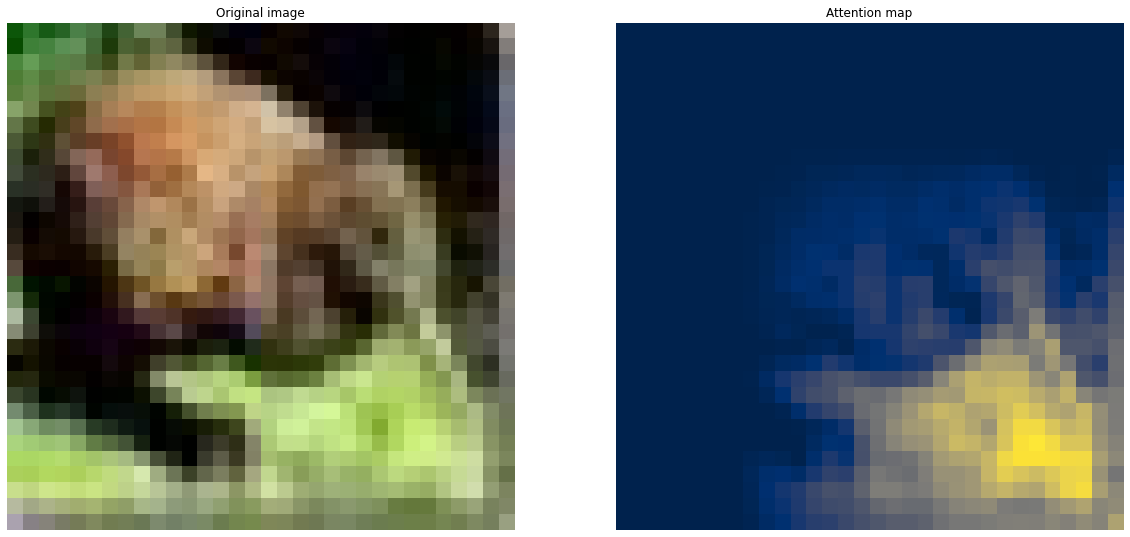

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
#generate org image
data_aug_org =get_transforms_original(im.size[0],im.size[1])
im = data_aug_org(im)
#generate sample image
data_aug = get_transforms(image_size,image_size)
sample = data_aug(im)
sample = sample.unsqueeze(0)
im = data_aug_org(im)
#plot original image
axs[0].imshow((np.array(1)* im))
axs[0].grid(None)
axs[0].axis('off')
axs[0].set_title('Original image')
#get attention maps
print(sample)
output,attn  = model(sample) #******da vedere bene perche*****
ps = int(image_size/16)
#softmax score without class token
attn2 = attn[0].clone().reshape(ps*ps+1)[1:].softmax(dim=-1).reshape((ps,ps))
mask = attn2.detach().numpy()
#resize attention map to original image size
mask = cv2.resize(mask/mask.max(), im.size)[..., np.newaxis]
#normalize attention map
mask =((mask - mask.min())/(mask.max() - mask.min()))
result = ((mask) * im).astype("uint8")
result = rgb2gray(result)
#plot attention maps
axs[1].imshow(result,cmap='cividis')
axs[1].grid(None)
axs[1].axis('off')
axs[1].set_title('Attention map')
plt.show()